In [1]:
#Loading in packages
import scvi
import anndata as ad #building anndata objects
import scanpy as sc # Single cell analysis 
import pandas as pd # dataframe manipulation 
import numpy as np
from scipy.io import mmread #Reading in mtx file 
from scipy.sparse import csr_matrix #convert from coo to csr matrix
from rich import print
import seaborn as sns
import os

/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
#-----Setting Seed-----#
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.3.0

In [3]:
#------Generating Anndata from Seurat Object-----#
conversion_dir = "/projects/b1217/HHA/Multiome_Scanpy_Conversion/Full_Atlas/"
#Contains metadata, barcodes, and umap embeddings 
metadata = pd.read_csv(os.path.join(conversion_dir, "SCRNA_Multiome_Metadata_PreIntegration_Final_3_31_25.csv"))
#Reading in the count matrix from seurat.combined
counts = mmread(os.path.join(conversion_dir, "SCRNA_Multiome_RawCounts_Final_3_31_25.mtx"))
counts = csr_matrix(counts.transpose()) #transposing to cell x gene matrix and converting to csr format
#Contains gene names 
gene_names = pd.read_csv(os.path.join(conversion_dir, "SCRNA_Multiome_GeneNames_Final_3_31_25.csv"))
stress_genes = pd.read_csv(os.path.join(conversion_dir, "SCRNA_Multiome_StressSig_LogNorm_Final_3_31_25.csv"))
#Setting index
stress_genes = stress_genes.set_index("Barcode")
cc_genes = pd.read_csv(os.path.join(conversion_dir, "SCRNA_Multiome_CellCycle_LogNorm_Final_3_31_25.csv"))
#Setting index
cc_genes = cc_genes.set_index("Barcode")
#Converting to anndata object
HHA = ad.AnnData(counts) #creating anndata object
HHA.obs_names = metadata["barcode"] #Adding barcodes as obs names 
HHA.var_names = gene_names["gene"] #adding gene names 
print(HHA)
print(HHA[:10])
print(HHA[:10])

/tmp/ipykernel_2448011/1060102141.py:4: DtypeWarning: Columns (13,23,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(os.path.join(conversion_dir, "SCRNA_Multiome_Metadata_PreIntegration_Final_3_31_25.csv"))


AnnData object with n_obs × n_vars = 128185 × 2469

View of AnnData object with n_obs × n_vars = 10 × 2469

View of AnnData object with n_obs × n_vars = 10 × 2469

In [4]:
#------Adding metadata to anndata--------#
#Adding in dataset information
HHA.obs["SampleID"] = pd.Categorical(metadata["SampleID"])
HHA.obs["DonorID"] = pd.Categorical(metadata["DonorID"])
HHA.obs["Platform"] = pd.Categorical(metadata["Platform"])
HHA.obs["Isolation"] = pd.Categorical(metadata["Isolation"])
HHA.obs["Sex"] = pd.Categorical(metadata["Sex"])
HHA.obs["Age"] = pd.Categorical(metadata["Age"])
HHA.obs["Source"] = pd.Categorical(metadata["Source"])
HHA.obs["Phase"] = pd.Categorical(metadata["Phase"])
HHA.obs["nCount_RNA"] = metadata["nCount_RNA"].values
HHA.obs["nFeature_RNA"] = metadata["nFeature_RNA"].values
HHA.obs["percent.mt"] = metadata["percent.mt"].values
HHA.obs["percent.ribo"] = metadata["percent.ribo"].values
HHA.obs["DissociationScore"] = metadata["DissociationScore"].values
#Saving Count Layer
HHA.layers["counts"] = HHA.X.copy()
print(HHA.obs.head(10))

#-----Adding normalized stress gene expression to obs-----#
for gene in stress_genes.columns:
    HHA.obs[gene] = stress_genes[gene]
    
#-----Adding normalized cell cycle gene expression to obs-----#
for gene in cc_genes.columns:
    HHA.obs[gene] = cc_genes[gene]
HHA.obs

SampleID DonorID Platform Isolation Sex Age    Source  \
barcode                                                                      
CAGTTAGTCGCAGAGA-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
GTTCATTAGTTGCTGT-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
TTCTCTCGTAGGTACG-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
TGGAGGACAACACAAA-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
CGGACACAGCCATGCC-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
CAATACGGTAGTTACC-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
TCTTCCTTCGGTCTGG-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
GTCGTTCTCGGTCATA-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
TCACATTTCCCGATCT-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   
AAACGCTAGGCATGCA-1_1    EL_A5       1     V3.1       FUE   M  37  Surgical   

                     Phase  nCount_RNA  nFeature_RNA  percent.mt  \
barcode                                                            
CAGTTAGTCGCAGAGA-1_1    G1       64894          7965    2.588837   
GTTCATTAGTTGCTGT-1_1     S       64476          7727    8.094485   
TTCTCTCGTAGGTACG-1_1    G1       62659          6821    2.271023   
TGGAGGACAACACAAA-1_1    G1       62457          7663    3.482396   
CGGACACAGCCATGCC-1_1   G2M       62297          7561    1.549031   
CAATACGGTAGTTACC-1_1    G1       62210          7082    4.155281   
TCTTCCTTCGGTCTGG-1_1    G1       61682          7959    1.092701   
GTCGTTCTCGGTCATA-1_1    G1       60657          7581    5.082678   
TCACATTTCCCGATCT-1_1     S       60182          7394    5.732611   
AAACGCTAGGCATGCA-1_1     S       59466          7195    6.484378   

                      percent.ribo  DissociationScore  
barcode                                                
CAGTTAGTCGCAGAGA-1_1      9.644959           0.798283  
GTTCATTAGTTGCTGT-1_1     16.375085           0.896463  
TTCTCTCGTAGGTACG-1_1      3.297212           0.673961  
TGGAGGACAACACAAA-1_1     30.139136           0.720352  
CGGACACAGCCATGCC-1_1     23.371912           0.872299  
CAATACGGTAGTTACC-1_1     13.549269           0.223532  
TCTTCCTTCGGTCTGG-1_1      5.760189           0.607349  
GTCGTTCTCGGTCATA-1_1     22.877821           0.804107  
TCACATTTCCCGATCT-1_1     17.179555           0.852641  
AAACGCTAGGCATGCA-1_1     33.765513           0.370231

/tmp/ipykernel_2448011/1192415611.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  HHA.obs[gene] = cc_genes[gene]
/tmp/ipykernel_2448011/1192415611.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  HHA.obs[gene] = cc_genes[gene]
/tmp/ipykernel_2448011/1192415611.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

,SampleID,DonorID,Platform,Isolation,Sex,Age,Source,Phase,nCount_RNA,nFeature_RNA,...,PCNA,TPX2,UBE2C,AURKA,CHAF1B,CDC45,MCM5,RANGAP1,GTSE1,POLA1
barcode,,,,,,,,,,,,,,,,,,,,,
CAGTTAGTCGCAGAGA-1_1,EL_A5,1,V3.1,FUE,M,37,Surgical,G1,64894,7965,...,0.143319,0.0,0.000000,0.0,0.143319,0.0,0.000000,0.268648,0.0,0.480195
GTTCATTAGTTGCTGT-1_1,EL_A5,1,V3.1,FUE,M,37,Surgical,S,64476,7727,...,0.144184,0.0,0.000000,0.0,0.144184,0.0,0.000000,1.154158,0.0,0.574072
TTCTCTCGTAGGTACG-1_1,EL_A5,1,V3.1,FUE,M,37,Surgical,G1,62659,6821,...,0.148070,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.822750,0.0,0.000000
TGGAGGACAACACAAA-1_1,EL_A5,1,V3.1,FUE,M,37,Surgical,G1,62457,7663,...,0.148515,0.0,0.000000,0.0,0.000000,0.0,0.277799,0.148515,0.0,0.148515
CGGACACAGCCATGCC-1_1,EL_A5,1,V3.1,FUE,M,37,Surgical,G2M,62297,7561,...,0.278421,0.0,0.148869,0.0,0.000000,0.0,0.000000,0.148869,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATTAGTCCAGGTTATT-1_5,EL_E8,5,Multiome,Bulb,M,34,Donor,G1,1051,639,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
GTGGTTAGTCCGCTGT-1_5,EL_E8,5,Multiome,Bulb,M,34,Donor,G1,1006,574,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
AACGCTAGTGTGTGGT-1_5,EL_E8,5,Multiome,Bulb,M,34,Donor,G1,1032,576,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [5]:
#-----Setting Up SCVI Model-----#
#Specifying the donor and sequencing platform as additional categorical covariates for integration
#Not including mitochondrial and ribosomal percentage or cell cycle as covariates, as this may mask real biology
continuous_covariates = stress_genes.columns.to_list() + cc_genes.columns.to_list() + ["nCount_RNA", "nFeature_RNA", "percent.mt", "percent.ribo"]
scvi.model.SCVI.setup_anndata(HHA, layer="counts", 
                              batch_key="SampleID",
                              categorical_covariate_keys = ["DonorID", "Sex", "Platform"],
                              continuous_covariate_keys = continuous_covariates)
model = scvi.model.SCVI(HHA, n_layers=2, n_latent=50, gene_likelihood= 'nb')
# view anndata_setup as a sanity check
model.view_anndata_setup()


/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/scvi/data/_utils.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[alternate_column_key] = codes
/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  getattr(adata, self.attr_name)[self.attr_key] = np.zeros(length, dtype=np.int64)


Anndata setup with scvi-tools version 1.3.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['DonorID', 'Sex', 'Platform'],
│   'continuous_covariate_keys': [
│   │   'ID3',
│   │   'JUN',
│   │   'BTG2',
│   │   'ATF3',
│   │   'HSPE1',
│   │   'CXCL1',
│   │   'EGR1',
│   │   'DUSP1',
│   │   'HSPA1A',
│   │   'HSPA1B',
│   │   'HSP90AB1',
│   │   'HSPB1',
│   │   'CEBPD',
│   │   'DNAJA1',
│   │   'HSPA8',
│   │   'NR4A1',
│   │   'UBC',
│   │   'HSPH1',
│   │   'NFKBIA',
│   │   'FOS',
│   │   'HSP90AA1',
│   │   'SOCS3',
│   │   'JUNB',
│   │   'IER2',
│   │   'DNAJB1',
│   │   'JUND',
│   │   'ZFP36',
│   │   'FOSB',
│   │   'PPP1R15A',
│   │   'CEBPB',
│   │   'CLSPN',
│   │   'CDCA8',
│   │   'CDC20',
│   │   'KIF2C',
│   │   'NASP',
│   │   'USP1',
│   │   'PSRC1',
│   │   'ANP32E',
│   │   'CKS1B',
│   │   'NUF2',
│   │   'NEK2',
│   │   'DTL',
│   │   'CENPF',
│   │   'LBR',
│   │   'EXO1',
│   │   'RRM2',
│   │   'CENPA',
│   │   'MSH2',
│   │   'BUB1',
│   │   'POLR1B',
│   │   'CKAP2L',
│   │   'MCM6',
│   │   'CDCA7',
│   │   'HJURP',
│   │   'SMC4',
│   │   'ECT2',
│   │   'SLBP',
│   │   'TACC3',
│   │   'CENPE',
│   │   'HMGB2',
│   │   'CENPU',
│   │   'MRPL36',
│   │   'CDC25C',
│   │   'HMMR',
│   │   'GMNN',
│   │   'TTK',
│   │   'CASP8AP2',
│   │   'ANLN',
│   │   'RFC2',
│   │   'MCM7',
│   │   'CDCA2',
│   │   'MCM4',
│   │   'CCNE2',
│   │   'DSCC1',
│   │   'ATAD2',
│   │   'CKS2',
│   │   'TUBB4B',
│   │   'CDK1',
│   │   'KIF20B',
│   │   'KIF11',
│   │   'HELLS',
│   │   'MKI67',
│   │   'RRM1',
│   │   'E2F8',
│   │   'CKAP5',
│   │   'FEN1',
│   │   'POLD3',
│   │   'RAD51AP1',
│   │   'NCAPD2',
│   │   'CDCA3',
│   │   'CBX5',
│   │   'PRIM1',
│   │   'TMPO',
│   │   'GAS2L3',
│   │   'UNG',
│   │   'CKAP2',
│   │   'G2E3',
│   │   'DLGAP5',
│   │   'UBR7',
│   │   'RAD51',
│   │   'NUSAP1',
│   │   'WDR76',
│   │   'CCNB2',
│   │   'TIPIN',
│   │   'KIF23',
│   │   'BLM',
│   │   'CTCF',
│   │   'GINS2',
│   │   'PIMREG',
│   │   'AURKB',
│   │   'CDC6',
│   │   'TOP2A',
│   │   'JPT1',
│   │   'BIRC5',
│   │   'TYMS',
│   │   'NDC80',
│   │   'UHRF1',
│   │   'PCNA',
│   │   'TPX2',
│   │   'UBE2C',
│   │   'AURKA',
│   │   'CHAF1B',
│   │   'CDC45',
│   │   'MCM5',
│   │   'RANGAP1',
│   │   'GTSE1',
│   │   'POLA1',
│   │   'nCount_RNA',
│   │   'nFeature_RNA',
│   │   'percent.mt',
│   │   'percent.ribo'
│   ]
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   16   │
│         n_cells          │ 128185 │
│ n_extra_categorical_covs │   3    │
│ n_extra_continuous_covs  │  131   │
│         n_labels         │   1    │
│          n_vars          │  2469  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │   EL_A5    │          0          │
│                       │   EL_A6    │          1          │
│                       │   EL_B6    │          2          │
│                       │   EL_B7    │          3          │
│                       │   EL_B8    │          4          │
│                       │   EL_C5    │          5          │
│                       │   EL_C6    │          6          │
│                       │   EL_E1    │          7          │
│                       │   EL_E3    │          8          │
│                       │   EL_E5    │          9          │
│                       │   EL_E6    │         10          │
│                       │   EL_E7    │         11          │
│                       │   EL_E8    │         12          │
│                       │   EL_H3    │         13          │
│                       │   EL_H5    │         14          │
│                       │   EL_H6    │         15          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['DonorID']  │     1      │          0          │
│                       │     2      │          1          │
│                       │     3      │          2          │
│                       │     4      │          3          │
│                       │     5      │          4          │
│                       │     6      │          5          │
│                       │     7      │          6          │
│                       │     8      │          7          │
│                       │     9      │          8          │
│                       │            │                     │
│ adata.obs['Platform'] │  Multiome  │          0          │
│                       │    V3.1    │          1          │
│                       │     V4     │          2          │
│                       │            │                     │
│   adata.obs['Sex']    │     F      │          0          │
│                       │     M      │          1          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

 extra_continuous_covs State 
          Registry           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     adata.obs['ID3']      │
│     adata.obs['JUN']      │
│     adata.obs['BTG2']     │
│     adata.obs['ATF3']     │
│    adata.obs['HSPE1']     │
│    adata.obs['CXCL1']     │
│     adata.obs['EGR1']     │
│    adata.obs['DUSP1']     │
│    adata.obs['HSPA1A']    │
│    adata.obs['HSPA1B']    │
│   adata.obs['HSP90AB1']   │
│    adata.obs['HSPB1']     │
│    adata.obs['CEBPD']     │
│    adata.obs['DNAJA1']    │
│    adata.obs['HSPA8']     │
│    adata.obs['NR4A1']     │
│     adata.obs['UBC']      │
│    adata.obs['HSPH1']     │
│    adata.obs['NFKBIA']    │
│     adata.obs['FOS']      │
│   adata.obs['HSP90AA1']   │
│    adata.obs['SOCS3']     │
│     adata.obs['JUNB']     │
│     adata.obs['IER2']     │
│    adata.obs['DNAJB1']    │
│     adata.obs['JUND']     │
│    adata.obs['ZFP36']     │
│     adata.obs['FOSB']     │
│   adata.obs['PPP1R15A']   │
│    adata.obs['CEBPB']     │
│    adata.obs['CLSPN']     │
│    adata.obs['CDCA8']     │
│    adata.obs['CDC20']     │
│    adata.obs['KIF2C']     │
│     adata.obs['NASP']     │
│     adata.obs['USP1']     │
│    adata.obs['PSRC1']     │
│    adata.obs['ANP32E']    │
│    adata.obs['CKS1B']     │
│     adata.obs['NUF2']     │
│     adata.obs['NEK2']     │
│     adata.obs['DTL']      │
│    adata.obs['CENPF']     │
│     adata.obs['LBR']      │
│     adata.obs['EXO1']     │
│     adata.obs['RRM2']     │
│    adata.obs['CENPA']     │
│     adata.obs['MSH2']     │
│     adata.obs['BUB1']     │
│    adata.obs['POLR1B']    │
│    adata.obs['CKAP2L']    │
│     adata.obs['MCM6']     │
│    adata.obs['CDCA7']     │
│    adata.obs['HJURP']     │
│     adata.obs['SMC4']     │
│     adata.obs['ECT2']     │
│     adata.obs['SLBP']     │
│    adata.obs['TACC3']     │
│    adata.obs['CENPE']     │
│    adata.obs['HMGB2']     │
│    adata.obs['CENPU']     │
│    adata.obs['MRPL36']    │
│    adata.obs['CDC25C']    │
│     adata.obs['HMMR']     │
│     adata.obs['GMNN']     │
│     adata.obs['TTK']      │
│   adata.obs['CASP8AP2']   │
│     adata.obs['ANLN']     │
│     adata.obs['RFC2']     │
│     adata.obs['MCM7']     │
│    adata.obs['CDCA2']     │
│     adata.obs['MCM4']     │
│    adata.obs['CCNE2']     │
│    adata.obs['DSCC1']     │
│    adata.obs['ATAD2']     │
│     adata.obs['CKS2']     │
│    adata.obs['TUBB4B']    │
│     adata.obs['CDK1']     │
│    adata.obs['KIF20B']    │
│    adata.obs['KIF11']     │
│    adata.obs['HELLS']     │
│    adata.obs['MKI67']     │
│     adata.obs['RRM1']     │
│     adata.obs['E2F8']     │
│    adata.obs['CKAP5']     │
│     adata.obs['FEN1']     │
│    adata.obs['POLD3']     │
│   adata.obs['RAD51AP1']   │
│    adata.obs['NCAPD2']    │
│    adata.obs['CDCA3']     │
│     adata.obs['CBX5']     │
│    adata.obs['PRIM1']     │
│     adata.obs['TMPO']     │
│    adata.obs['GAS2L3']    │
│     adata.obs['UNG']      │
│    adata.obs['CKAP2']     │
│     adata.obs['G2E3']     │
│    adata.obs['DLGAP5']    │
│     adata.obs['UBR7']     │
│    adata.obs['RAD51']     │
│    adata.obs['NUSAP1']    │
│    adata.obs['WDR76']     │
│    adata.obs['CCNB2']     │
│    adata.obs['TIPIN']     │
│    adata.obs['KIF23']     │
│     adata.obs['BLM']      │
│     adata.obs['CTCF']     │
│    adata.obs['GINS2']     │
│    adata.obs['PIMREG']    │
│    adata.obs['AURKB']     │
│     adata.obs['CDC6']     │
│    adata.obs['TOP2A']     │
│     adata.obs['JPT1']     │
│    adata.obs['BIRC5']     │
│     adata.obs['TYMS']     │
│    adata.obs['NDC80']     │
│    adata.obs['UHRF1']     │
│     adata.obs['PCNA']     │
│     adata.obs['TPX2']     │
│    adata.obs['UBE2C']     │
│    adata.obs['AURKA']     │
│    adata.obs['CHAF1B']    │
│    adata.obs['CDC45']     │
│     adata.obs['MCM5']     │
│   adata.obs['RANGAP1']    │
│    adata.obs['GTSE1']     │
│    adata.obs['POLA1']     │
│  adata.obs['nCount_RNA']  │
│ adata.ob

In [6]:
#Training model using gpu acceleration
model.train(max_epochs = 500, early_stopping = True) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/lightning/pytorch/traine

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 939.735. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

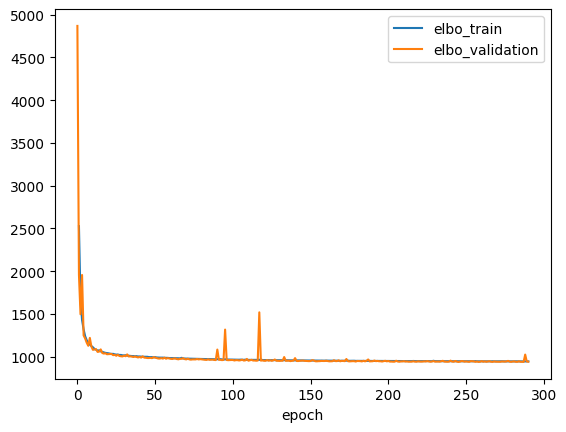

In [7]:
#-----Plotting Model convergence-----#
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [8]:
#-----Extracting Latent Representation from Model----#
HHA.obsm["X_scVI"] = model.get_latent_representation()
HHA.obsm["X_scVI"]

#----Leiden Clustering with default Scanpy workflow------#
sc.pp.neighbors(HHA, use_rep= "X_scVI")
sc.tl.leiden(HHA)
sc.tl.umap(HHA)

/tmp/ipykernel_2448011/2676788246.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(HHA)
/projects/b1217/Chris/condaenvs/SCVIEnv/lib/python3.11/site-packages/scanpy/tools/_leiden.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(


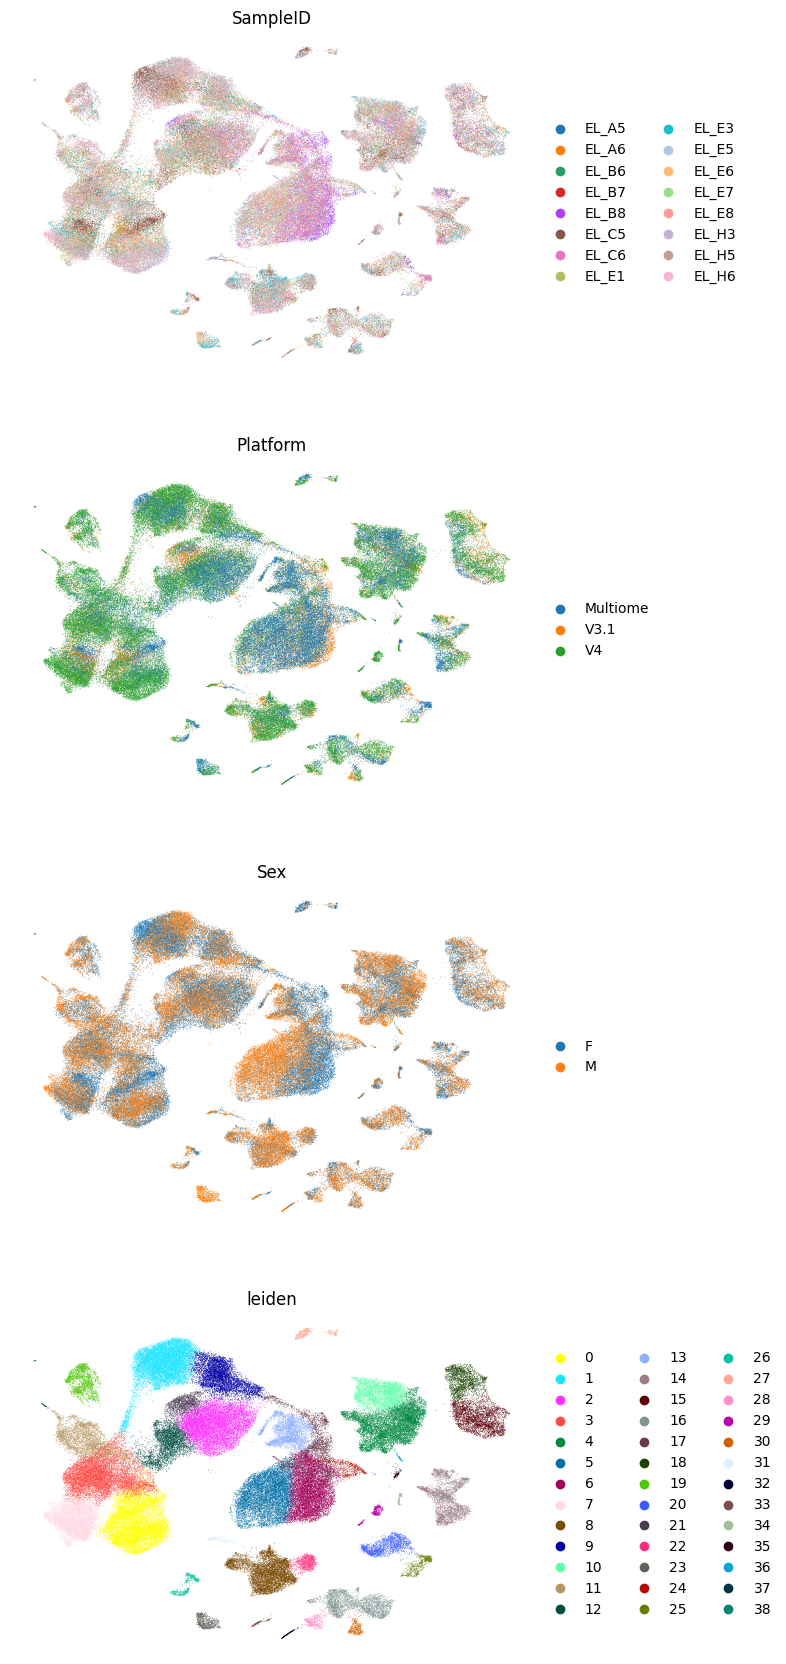

In [9]:
#----- Quickly Visualizing results with UMAP embeddding------#
sc.pl.embedding(
    HHA,
    basis="X_umap",
    color=["SampleID",'Platform', 'Sex', 'leiden'],
    frameon=False,
    add_outline=False,
    ncols=1)

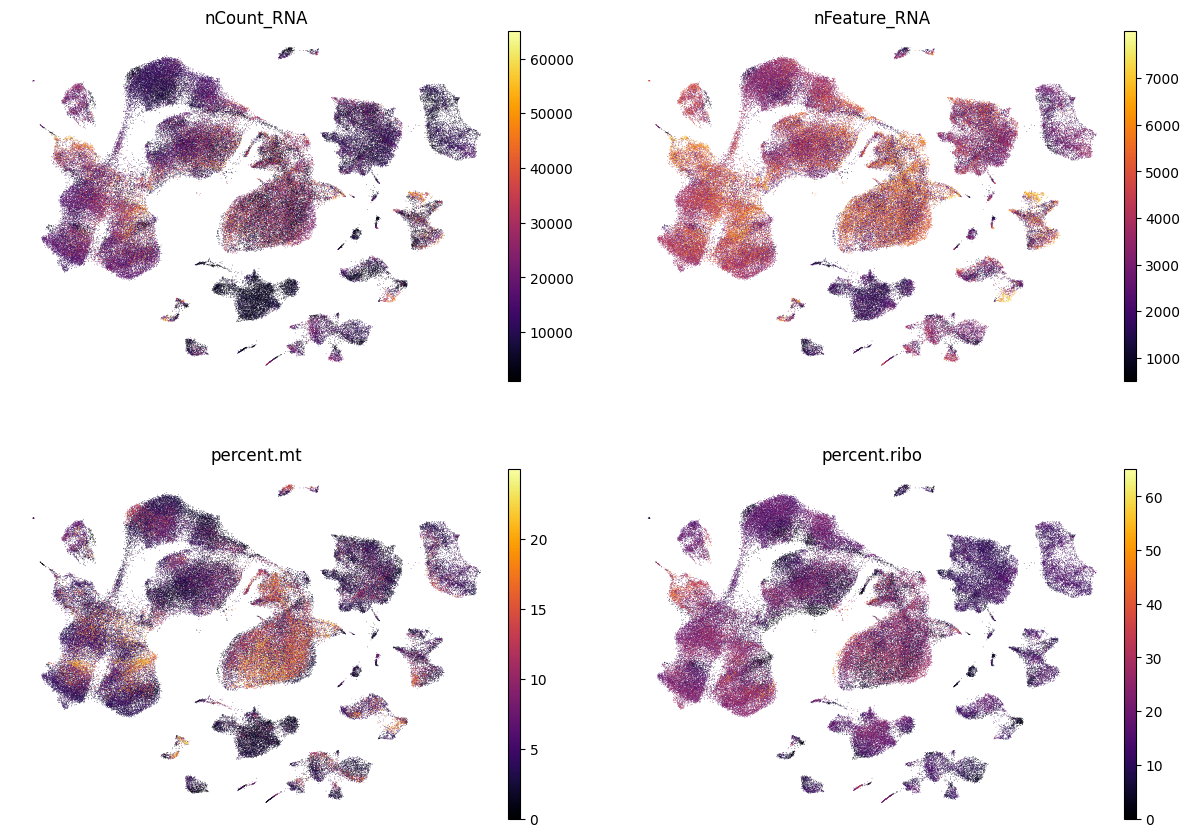

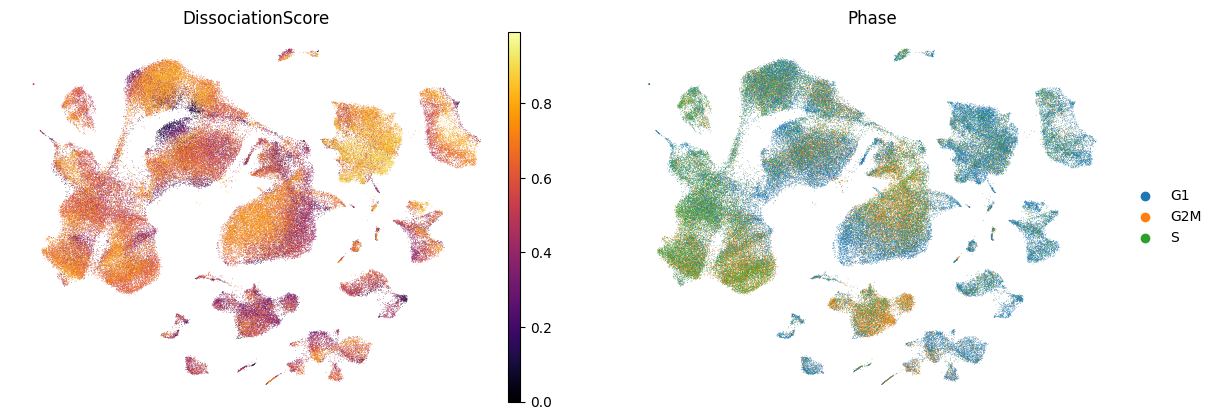

In [11]:
#-----Checking QC Metric mixing in UMAP embeddings------#
sc.pl.embedding(HHA, basis="X_umap",
                color=["nCount_RNA", "nFeature_RNA", "percent.mt", "percent.ribo"],
                add_outline=False,
                cmap = "inferno", 
                frameon=False, 
                ncols=2)
sc.pl.embedding(HHA, basis="X_umap",
                color=["DissociationScore", "Phase"],
                cmap = "inferno",
                add_outline=False,
                frameon=False, 
                ncols=2)

In [12]:
#-------Extracting SCVI Latent Dimensions and Writing to CSV-----#
HHA_Latent = pd.DataFrame(HHA.obsm["X_scVI"])
HHA_Latent.columns = ["SCVI_" + str(i) for i in range(1, 51)]
HHA_Latent["Barcode"] = HHA.obs_names
HHA_Latent.head(10)
HHA_Latent.to_csv(os.path.join(conversion_dir, "SCRNA_Multiome_RNA_LatentRep_Final_3_31_25.csv"), index = False)